November: Part 3 - This notebook is a continuation of gyre_runs.ipynb and gyre_runs_mackenzie01.ipynb. The configuration used to produce these results is gyre_mackenzie02. Parameters explored: ln_tsd_init, ln_tsd_tradmp, sn_tem, sn_sal.

Changes since Part 2:
* matlab scaling factors script has transposed lons and lats so it won't flip the dimensions
* masking land using [Nancy notebook](http://nbviewer.jupyter.org/urls/bitbucket.org/salishsea/analysis-nancy/raw/tip/notebooks/Masking%20with%20tmask.ipynb)
* now, we have the realistic bathymetry that matches the idealized bathymetry
* the idealized bathymetry has been refined (slope)
* the stratification based on Arctic data is inputted into the model

In [12]:
import numpy as np
import netCDF4 as nc
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cmocean as cmo
%matplotlib inline

import sys
sys.path.append('/ocean/imachuca/Canyons/mackenzie_canyon/bathymetry/modules/')
import functions_plot

from salishsea_tools import nc_tools

In [51]:
def plot_gyre_times(gridT, var, depth_ind, time_inds, cmin, cmax, cmaps, max_min, supttl):
    cmaps.set_bad('wheat')
    fig, ax = plt.subplots(1, len(time_inds), figsize=(20, 4.5), sharex=True, sharey=True)
    for i, n in zip(time_inds, np.arange(len(time_inds))):
        if max_min == True:
            c = ax[n].pcolormesh(var[i,depth_ind,:,:], cmap=cmaps, vmin = cmin, vmax = cmax)
            if n == 0:
                cbar = fig.colorbar(c, ax=ax[0])
        elif max_min == False:
            c = ax[n].pcolormesh(var[i,depth_ind,:,:], cmap=cmaps)
            cbar = fig.colorbar(c, ax=ax[n])
        timestamp = nc_tools.timestamp(gridT,i).format('HH:mm')
        ax[n].set_title('time: ' + timestamp, fontsize=16)
        ax[n].set_xlim(0,gridT.dimensions['x'].size)
        ax[n].set_ylim(0,gridT.dimensions['y'].size)
        ax[n].xaxis.set_visible(False); ax[n].yaxis.set_visible(False)
    title = supttl + ' at ' + str(int(gridT['deptht'][depth_ind])) + 'm'
    fig.tight_layout(); fig.subplots_adjust(top=0.85); fig.suptitle(title, fontsize=20)
    return fig

## Summary


* cp_cfg name
* bathy_meter.nc and coordinates.nc
* nn_bathy = 1 (0 for compute)
* jphgr_msh = 0 (5 for gyre)
* jperio = 1 (cyclic)
* ln_zco, ln_zps
* jpidta = jpiglo, jpjdta = jpjglo, jpkdta 


|Parameter      |Run01 (Id)|Run01 (Re)|
|---------------|----------|----------|
|cp_cfg         |ideal     |real      |
|ln_bt_nn_auto  |False     |True      |
|rn_bt_cmax     |NA        |0.05      |
|rn_rdt         |20        |10        |
|nn_baro        |4         |NA        |
|calc nn_baro   |NA        |5         |
|nn_itend       |2160 (12h)|4320 (12h)|
|nn_write       |360 (1h)  |---       |
|nn_tau000 [ts] |540 (3h)  |1080      |
|rn_utau0 [N/m2]|-5.0      |-5.0      |
|rn_vtau0 [N/m2]|0         |0         |
|status         | ✓(2160)  | ✓ (4320) |

* under these nn_itend and nn_write, the stages where the code can fail are [1, 361, 721, 1081, 1441, 1801]
* from Part 2, remember you have to reduce timestep and then consider the wind forcing

In [14]:
# calculate nn_baro using rn_rdt and cmax
g = 9.81; cmax = 0.05; dx = 4501; H = 1300; dt_clinic = 10 #(rn_rdt)
u = np.sqrt(g * H)
dt_tropic = (cmax * dx) / u
iterations = dt_clinic / dt_tropic
iterations

5.0179596244528888

# Run01: Idealized vs Realistic

These runs use a configuration similar to the ones that are proven to run from gyre_runs_mackenzie01.ipynb. Both runs try to simulate the same scenario. The realistic needed a smaller timestep so nn_itend and nn_tau were modified to accommodate this change. The original gyre stratification was used.

1. mackenzie_canyon/bathymetry/initial_sets/idealized/**ideal_bathy_01.nc**
2. mackenzie_canyon/bathymetry/initial_sets/realistic/**real_bathy_01.nc**
3. mackenzie_canyon/bathymetry/initial_sets/coordinates/**coords_01.nc**

In [15]:
path = '/ocean/imachuca/NEMO-3.6-code/NEMOGCM/CONFIG/'
cfg = 'gyre_mackenzie02/EXP00/runs_idealized/Run01'
gridT_I1, lon_I1, lat_I1, tem_I1, sal_I1, ssh_I1, U_I1, V_I1, W_I1 = functions_plot.load_model_output(path, cfg)

path = '/ocean/imachuca/NEMO-3.6-code/NEMOGCM/CONFIG/'
cfg = 'gyre_mackenzie02/EXP00/runs_realistic/Run01'
gridT_R1, lon_R1, lat_R1, tem_R1, sal_R1, ssh_R1, U_R1, V_R1, W_R1 = functions_plot.load_model_output(path, cfg)

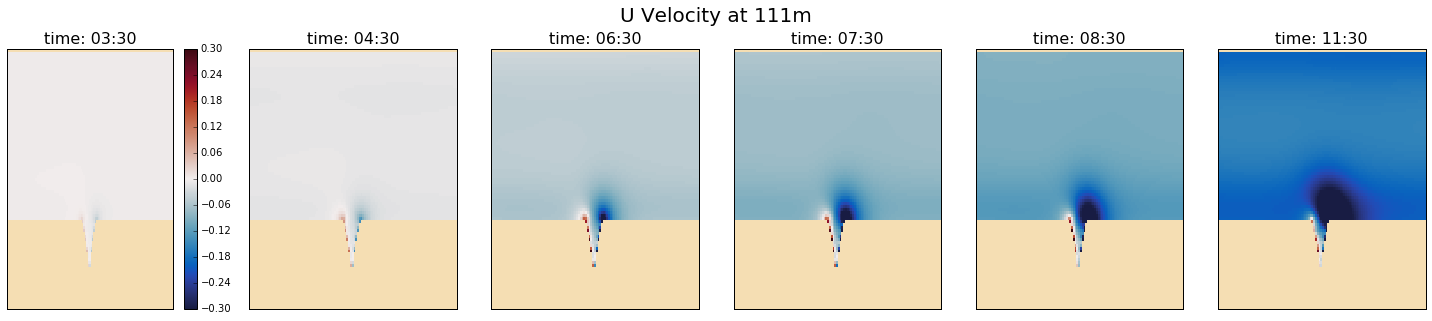

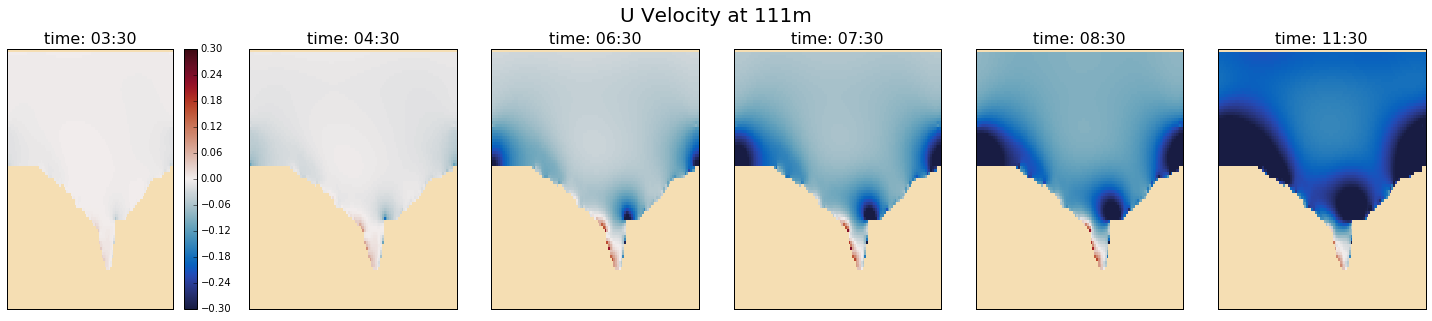

In [52]:
dep = 8
time_inds = [3,4,6,7,8,11]
bd = 0.3
max_min = True
supttl = 'U Velocity'
fig = plot_gyre_times(gridT_I1, U_I1, dep, time_inds, -bd, bd, cmo.cm.balance, max_min, supttl)
fig = plot_gyre_times(gridT_R1, U_R1, dep, time_inds, -bd, bd, cmo.cm.balance, max_min, supttl)

# Run02: Arctic Stratification

These runs have the **same configurations** as Run01 and still use **ideal_bathy_01.nc**, **real_bathy_01.nc**, and **coords_01.nc**. What's new is that these runs use the temperature and salinity files created in prepare_stratification.ipynb.

1. mackenzie_canyon/conditions/stratification_files/**temp_strat.nc** & **temp_strat_real.nc**
2. mackenzie_canyon/conditions/stratification_files/**salt_strat.nc** & **temp_strat_real.nc**

### Notes
(Pages 67 and 129) In namtsd, **ln_tsd_init** and **ln_tsd_tradmp** are True and **sn_tem** and **sn_sal** are:

| Parameter             | Description | Values|
|-----------------------|-------------|-------|
| File name             |can include directory, doesn't have to have .nc| 'temp_strat', 'salt_strat'|
| Record frequency      |contained in input file, +ive if hours, -ive if months, integer| 1|
| Variable name         |'votemper', 'vosaline'| 'votemper', 'vosaline'|
| Time interpolation    |false if forcing remains constant during each forcing period| false|
| Climatological forcing|true if input file contains climatological forcing which can be cycled in time| true|
| Open/close frequency  |forcing files have data from the beginning of one 'daily','weekLLL','monthly','yearly'| 'yearly'|


In [17]:
path = '/ocean/imachuca/NEMO-3.6-code/NEMOGCM/CONFIG/'
cfg = 'gyre_mackenzie02/EXP00/runs_idealized/Run02'
gridT_I2, lon_I2, lat_I2, tem_I2, sal_I2, ssh_I2, U_I2, V_I2, W_I2 = functions_plot.load_model_output(path, cfg)

path = '/ocean/imachuca/NEMO-3.6-code/NEMOGCM/CONFIG/'
cfg = 'gyre_mackenzie02/EXP00/runs_realistic/Run02'
gridT_R2, lon_R2, lat_R2, tem_R2, sal_R2, ssh_R2, U_R2, V_R2, W_R2 = functions_plot.load_model_output(path, cfg)

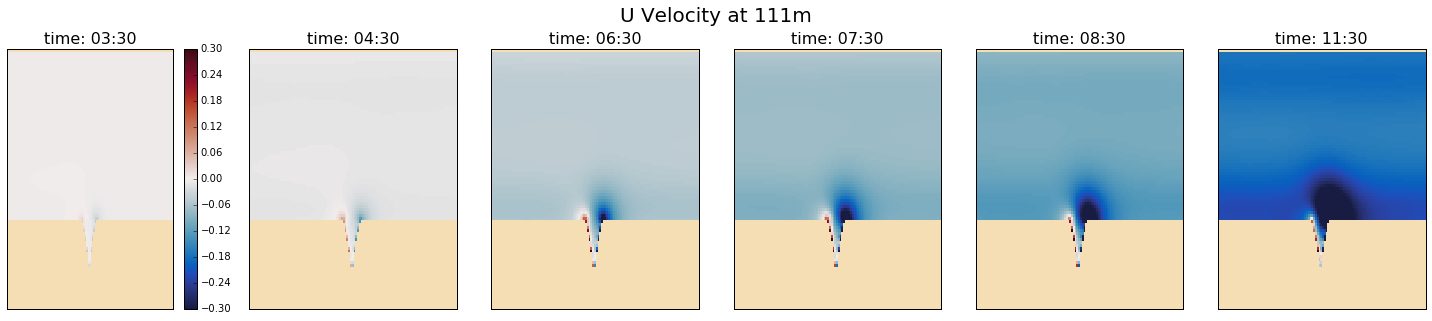

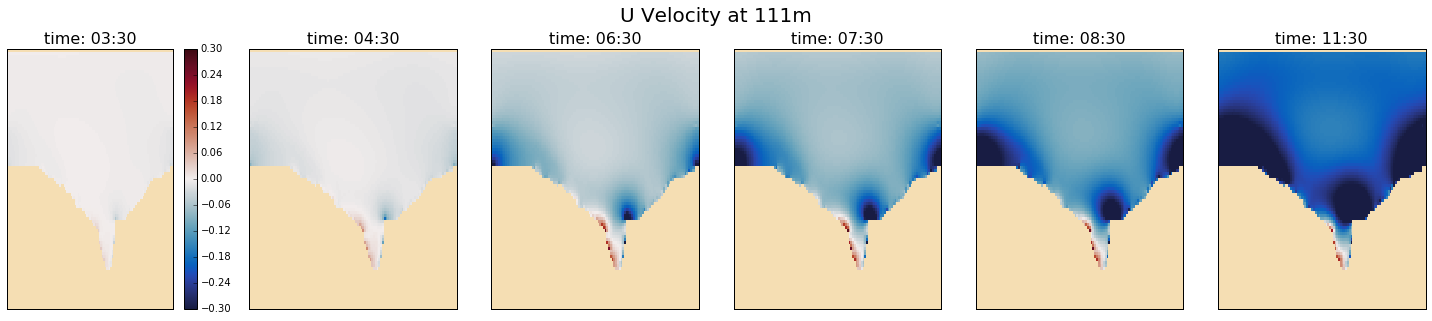

In [53]:
dep = 8
time_inds = [3,4,6,7,8,11]
bd = 0.3
max_min = True
supttl = 'U Velocity'
fig = plot_gyre_times(gridT_I2, U_I2, dep, time_inds, -bd, bd, cmo.cm.balance, max_min, supttl)
fig = plot_gyre_times(gridT_R2, U_R2, dep, time_inds, -bd, bd, cmo.cm.balance, max_min, supttl)

# Run03: Lateral Boundary Conditions

### Notes
(Page 154 to 157) In namlbc:

| Parameter             | Description | Run01 (Id & Re)| Run02 (Id & Re)| Run03 (Id)| Run04 (Id)|
|-----------------------|------------------------------------------------------------------------|---|---|-----|-----|
|rn_shlat|**free slip** = 0, 0 < **partial slip** < 2, **no slip** = 2, **strong slip** > 2| 0 | 0 | 0.5 | 2.0 |

In [19]:
path = '/ocean/imachuca/NEMO-3.6-code/NEMOGCM/CONFIG/'
cfg = 'gyre_mackenzie02/EXP00/runs_idealized/Run03'
gridT_I3, lon_I3, lat_I3, tem_I3, sal_I3, ssh_I3, U_I3, V_I3, W_I3 = functions_plot.load_model_output(path, cfg)

path = '/ocean/imachuca/NEMO-3.6-code/NEMOGCM/CONFIG/'
cfg = 'gyre_mackenzie02/EXP00/runs_idealized/Run04'
gridT_I4, lon_I4, lat_I4, tem_I4, sal_I4, ssh_I4, U_I4, V_I4, W_I4 = functions_plot.load_model_output(path, cfg)

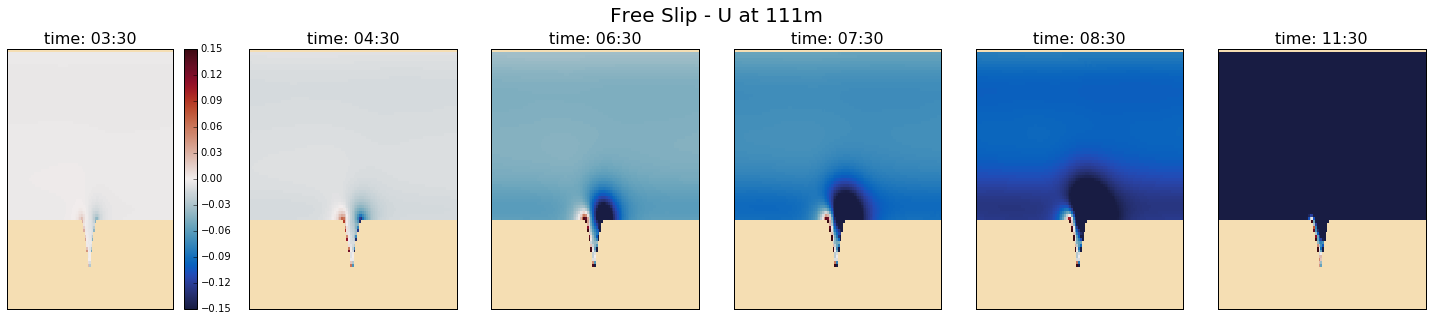

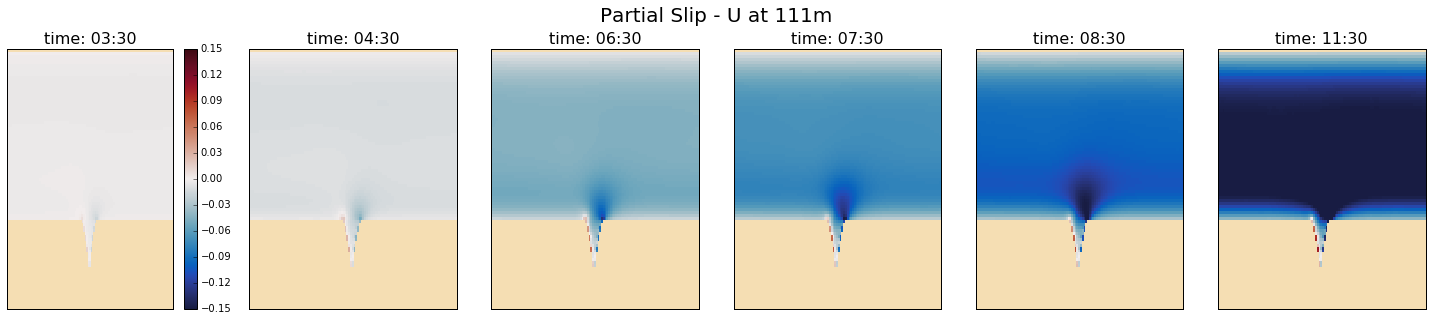

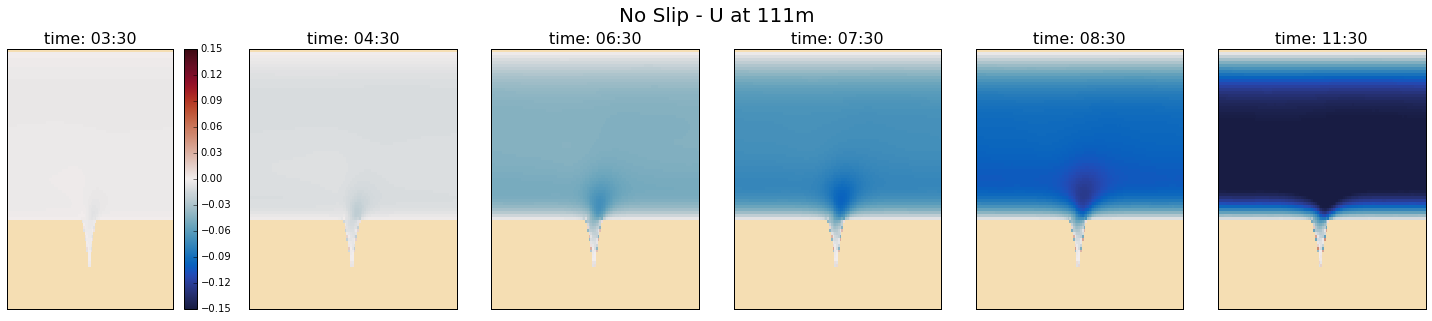

In [54]:
dep = 8
time_inds = [3,4,6,7,8,11]
bd = 0.15
max_min = True
supttl = 'U'
fig = plot_gyre_times(gridT_I2, U_I2, dep, time_inds, -bd, bd, cmo.cm.balance, max_min, 'Free Slip - '+supttl)
fig = plot_gyre_times(gridT_I3, U_I3, dep, time_inds, -bd, bd, cmo.cm.balance, max_min, 'Partial Slip - '+supttl)
fig = plot_gyre_times(gridT_I4, U_I4, dep, time_inds, -bd, bd, cmo.cm.balance, max_min, 'No Slip - '+supttl)